In [1]:
import os
os.chdir('../')

### from "sample noise data pair by Euler and save pt.ipynb"

In [2]:
import torch
import torch.nn.functional as F

save_file = 'optimization/pair/euler_NFE=120_N=256_data_evaluations.pt'
data = torch.load(save_file)
target = data['target']
hist = data['hist']
print(target.shape, hist.shape)

torch.Size([256, 3, 64, 64]) torch.Size([120, 256, 3, 64, 64])


In [3]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random

from main import parse_args_and_config, Diffusion
from datasets import inverse_data_transform

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.benchmark = False

###############################################################################
# 1) Notebook에서 sys.argv를 직접 설정 (argparse 흉내)
###############################################################################
NFE = 5
sys.argv = [
    "main.py",
    "--config", "imagenet64.yml",  # 사용하려는 config
    "--sample",
    "--sample_type", "rbfsolverglq10hist",
    "--dpm_solver_type", "data_prediction",
    "--dpm_solver_order", "3",
    "--timesteps", str(NFE),
    "--skip_type", "logSNR",
    "--log_scale_min", "-6.0",
    "--log_scale_max", "6.0",
    "--log_scale_num", "100",
    "--scale_dir", "/data/data/rbfsolverglq10hist",
    "--ni"
]

###############################################################################
# 2) 인자/설정 로드
###############################################################################
args, config = parse_args_and_config()

###############################################################################
# 3) Diffusion 객체 생성 -> 모델 로딩
###############################################################################
diffusion = Diffusion(args, config, rank=0)
diffusion.prepare_model()
diffusion.model.eval()

###############################################################################
# 4) 배치(25장) 한 번에 샘플링 -> 5x5 그리드(여백 없이) 시각화
###############################################################################
device = diffusion.device


INFO - main.py - 2025-03-29 05:26:34,890 - Using device: cuda


[prepare_model] Loading ckpt from /data/checkpoints/dpm-solver/imagenet64_uncond_100M_1500K.pt ...
[prepare_model] Checkpoint loaded.
[prepare_model] Model is ready.


In [4]:
!mkdir /data/data/rbfsolverglq10hist

mkdir: cannot create directory ‘/data/data/rbfsolverglq10hist’: File exists


torch.Size([5, 256, 3, 64, 64])


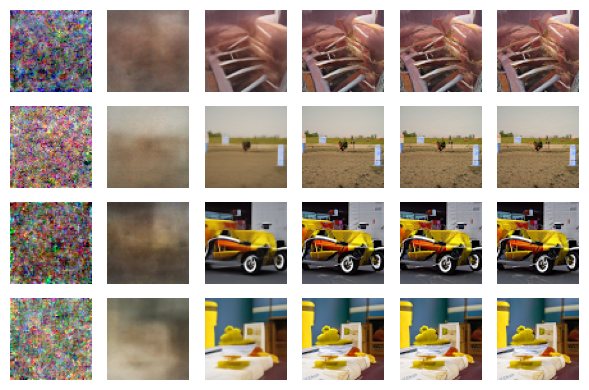

In [5]:
import torch

def uniform_resample_length(tensor: torch.Tensor, m: int) -> torch.Tensor:
    L, B, C, H, W = tensor.shape
    idx = torch.linspace(0, L - 1, m, device=tensor.device)
    left = idx.floor().long()
    right = (left + 1).clamp_max(L - 1)
    alpha = (idx - left.float()).view(-1, 1, 1, 1, 1)
    return tensor[left] * (1 - alpha) + tensor[right] * alpha

hist_resampled = uniform_resample_length(hist, NFE)
print(hist_resampled.shape)

import torch
import matplotlib.pyplot as plt

# hists_load.shape == [256, 120, 3, 64, 64]

# 인스턴스 16개, 스텝 12개(10 간격)
nrows, ncols = 4, NFE+1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))

for i in range(nrows):       # 인스턴스 인덱스 (0 ~ 15)
    for j in range(ncols):   # 스텝 간격 인덱스 (0 ~ 11)
        step = j        # 실제 스텝: 0, 10, 20, ..., 110
        
        if j < ncols-1:
            img_tensor = hist_resampled[step, i]
        else:
            img_tensor = target[i]
        
        # inverse_data_transform (원하는 config와 함께 사용)
        # 예) img_tensor = inverse_data_transform(config, img_tensor)
        img_tensor = inverse_data_transform(config, img_tensor)
        
        # PyTorch 차원(채널, 높이, 너비)을 (높이, 너비, 채널)로 바꾸기
        img = img_tensor.permute(1, 2, 0).cpu().numpy()
        
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        

plt.tight_layout()
plt.show()


In [6]:
n = 256
target_batch = target[:n].to(device)
hist_batch = hist_resampled[:n].to(device)
noise_batch = torch.randn_like(target_batch)
print(hist_batch.shape)

optimal_gammas, _ = diffusion.sample_image(noise_batch, diffusion.model, target=target_batch, hist=hist_batch, exp_num=0)
print(optimal_gammas)


torch.Size([5, 256, 3, 64, 64])
/data/data/rbfsolverglq10hist/NFE=5,p=3,exp_num=0.npy  saved!
[[-6.          0.3030303   0.18181818  0.18181818 -6.        ]
 [-0.66666667  5.15151515 -0.42424242 -0.42424242  0.        ]]


### Batch

In [2]:
import sys
import torch
import numpy as np
from main import parse_args_and_config, Diffusion
from tqdm import tqdm

def uniform_resample_length(tensor: torch.Tensor, m: int) -> torch.Tensor:
    L, B, C, H, W = tensor.shape
    idx = torch.linspace(0, L - 1, m, device=tensor.device)
    left = idx.floor().long()
    right = (left + 1).clamp_max(L - 1)
    alpha = (idx - left.float()).view(-1, 1, 1, 1, 1)
    return tensor[left] * (1 - alpha) + tensor[right] * alpha

save_file = 'optimization/pair/euler_NFE=120_N=256_data_evaluations.pt'
data = torch.load(save_file)
target = data['target']
hist = data['hist']

model = None
for NFE in tqdm([5, 10, 15, 25]):
    sys.argv = [
        "main.py",
        "--config", "imagenet64.yml",  # 사용하려는 config
        "--sample",
        "--sample_type", "rbfsolverglq10hist",
        "--dpm_solver_type", "data_prediction",
        "--dpm_solver_order", "3",
        "--timesteps", str(NFE),
        "--skip_type", "logSNR",
        "--log_scale_min", "-6.0",
        "--log_scale_max", "6.0",
        "--log_scale_num", "100",
        "--scale_dir", "/data/data/rbfsolverglq10hist",
        "--exp_num", "0",
        "--verbose", "critical",
        "--ni",
    ]

    args, config = parse_args_and_config()
    diffusion = Diffusion(args, config, rank=0)

    if model is None:
        diffusion.prepare_model()
        diffusion.model.eval()
        model = diffusion.model
    device = diffusion.device

    n = 256
    target_batch = target[:n].to(device)
    hist_batch = uniform_resample_length(hist, NFE)[:n].to(device)
    noise_batch = torch.randn_like(target_batch)
    optimal_gammas, _ = diffusion.sample_image(noise_batch, model, target=target_batch, hist=hist_batch, exp_num=0)
    print(optimal_gammas)

  0%|          | 0/4 [00:00<?, ?it/s]

[prepare_model] Loading ckpt from /data/checkpoints/dpm-solver/imagenet64_uncond_100M_1500K.pt ...
[prepare_model] Checkpoint loaded.
[prepare_model] Model is ready.


 25%|██▌       | 1/4 [00:01<00:03,  1.19s/it]

/data/data/rbfsolverglq10hist/NFE=5,p=3,exp_num=0.npy  saved!
[[-6.          0.3030303   0.18181818  0.18181818 -6.        ]
 [-0.66666667  5.15151515 -0.42424242 -0.42424242  0.        ]]


 50%|█████     | 2/4 [00:01<00:01,  1.42it/s]

/data/data/rbfsolverglq10hist/NFE=10,p=3,exp_num=0.npy  saved!
[[-6.          0.3030303   5.87878788  1.03030303  0.66666667  4.90909091
   4.3030303   4.3030303   0.54545455 -1.75757576]
 [-0.66666667  5.27272727  5.63636364  4.66666667 -0.18181818 -0.18181818
  -0.06060606 -0.06060606  0.06060606  0.        ]]


 75%|███████▌  | 3/4 [00:02<00:00,  1.57it/s]

/data/data/rbfsolverglq10hist/NFE=15,p=3,exp_num=0.npy  saved!
[[-2.60606061  0.42424242  4.06060606  3.93939394  3.81818182  4.3030303
   4.90909091  4.06060606  4.3030303   4.18181818  4.06060606  4.18181818
   5.75757576  5.87878788 -6.        ]
 [-0.66666667  5.51515152  5.63636364  5.15151515 -0.18181818  5.63636364
  -0.18181818 -0.18181818 -0.06060606 -0.06060606 -0.06060606 -0.06060606
  -0.06060606  4.42424242  0.        ]]


100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

/data/data/rbfsolverglq10hist/NFE=25,p=3,exp_num=0.npy  saved!
[[-6.          0.54545455  4.42424242  4.42424242  4.42424242  4.42424242
   4.42424242  4.06060606  4.42424242  5.87878788  4.06060606  5.03030303
   4.18181818  4.3030303   4.06060606  4.3030303   4.18181818  4.3030303
   4.90909091  4.42424242  4.3030303   5.03030303  5.63636364  5.75757576
  -6.        ]
 [-0.66666667  5.63636364  3.45454545  5.87878788  6.          6.
   5.87878788  4.78787879 -0.18181818  4.66666667  4.78787879 -0.06060606
  -0.06060606 -0.06060606 -0.06060606 -0.06060606 -0.06060606 -0.06060606
  -0.06060606 -0.06060606 -0.06060606  5.63636364  4.78787879  4.42424242
   0.        ]]


In [9]:
print('done')

done
